In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import random
import requests as rq
import sys
import io
from bs4 import BeautifulSoup
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import RMSprop
from collections import Counter
import keras
from keras.layers import Embedding
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
%matplotlib inline




# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/SupremeCourtNew'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-04-29 15:54:17.965115: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 15:54:17.965232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 15:54:18.086995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data = '/kaggle/input/supremecourtnew/SupremeCourtTranscriptNew.csv'
df = pd.read_csv(data, header=None,encoding='latin-1')
col_names = ['total_order', 'order', 'year', 'nominee', 'speaker_title', 'speaker_party', 'speaker_name','speaker_statement']
df.columns = col_names
col_names
df.head()

,total_order,order,year,nominee,speaker_title,speaker_party,speaker_name,speaker_statement
0,Total Order,Order,Year,Hearing,Title,Speaker (Party)(or nominated by),Speaker and title,Statements
1,1,1,2018,Brett M. Kavanaugh,Chairman,R,Senator Chuck Grassley (IA),Chairman GRASSLEY. I welcome everyone to this ...
2,2,2,2018,Brett M. Kavanaugh,Senator,D,Senator Kamala Harris (CA),Senator HARRIS. Mr. Chairman?
3,3,3,2018,Brett M. Kavanaugh,Chairman,R,Senator Chuck Grassley (IA),Chairman GRASSLEY [continuing]. Brett Kavanaugh
4,4,4,2018,Brett M. Kavanaugh,Senator,D,Senator Kamala Harris (CA),Senator HARRIS. Mr. Chairman?


In [3]:
df['nominee'].unique()
df['speaker_statement'] = df['speaker_statement'].apply(lambda x: x.split('.', 1)[-1].strip())
df['speaker_statement'] = df['speaker_statement'].str.replace(r'\[[^\]]*]\s*([^\.]*\.)?', '', regex=True)
df.loc[df['nominee'] =='Brett M. Kavanaugh II', 'nominee'] = 'Brett M. Kavanaugh'
df.loc[df['nominee'] =='Clarence Thomas II', 'nominee'] = 'Clarence Thomas'
df.loc[df['nominee'] =='Judge Robert Bork', 'nominee'] = 'Robert Bork'
df['nominee'].unique()
df['speaker_party'].unique()
df['speaker_party'].value_counts()
unaffiliated = df['speaker_party'].isnull()
df.loc[unaffiliated, 'speaker_party'] = 'Unaffiliated'

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.callbacks import EarlyStopping



speaker_statements = df['speaker_statement'].values
speaker_parties = df['speaker_party'].values

max_words = 5000 #Maximum number of words per sequence
max_len = 200 #Maximum length of a single word

sequences = [text_to_word_sequence(statement) for statement in speaker_statements]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['speaker_statement'])
sequences = tokenizer.texts_to_sequences(df['speaker_statement']) #Changes words into unique numbers
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length) #Makes all sentences the same length
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['speaker_party'])

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2)

Epoch 1/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 133s 145ms/step - accuracy: 0.5794 - loss: 0.8277 - val_accuracy: 0.6484 - val_loss: 0.6256
Epoch 2/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 130s 146ms/step - accuracy: 0.7172 - loss: 0.5552 - val_accuracy: 0.6710 - val_loss: 0.5913
Epoch 3/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 130s 146ms/step - accuracy: 0.7909 - loss: 0.4489 - val_accuracy: 0.7184 - val_loss: 0.5905
Epoch 4/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 129s 145ms/step - accuracy: 0.8450 - loss: 0.3425 - val_accuracy: 0.7129 - val_loss: 0.6367
Epoch 5/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 130s 146ms/step - accuracy: 0.8736 - loss: 0.2732 - val_accuracy: 0.7081 - val_loss: 0.6911
Epoch 5: early stopping


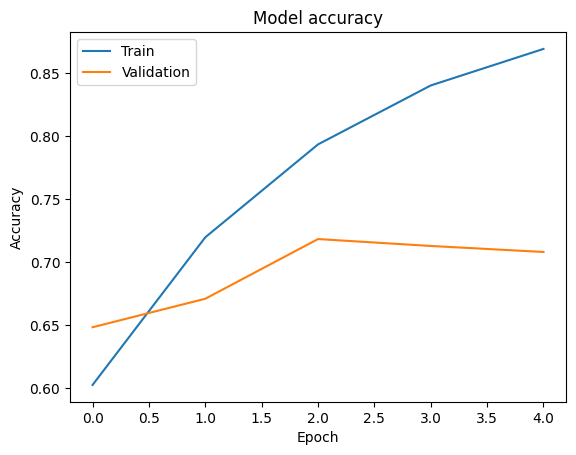

In [6]:
from keras.layers import Bidirectional, LSTM, Dropout

model = keras.Sequential([
    keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100), #Embedding Layer
    Bidirectional(LSTM(128, return_sequences=True)), #Bidirectional LSTM layer 
    Dropout(0.2), #Dropout Layer (0.2)
    Bidirectional(LSTM(64)), #Bidirectional LSTM layer
    Dropout(0.5), #Dropout layer (0.5)
    keras.layers.Dense(len(label_encoder.classes_), activation='softmax') #Dense layer/Output layer (outputs probabilities)
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, mode='max', verbose=1)

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
example = "?"
#"Do you believe in a woman's right to an abortion?"
#"Do you think a woman should be allowed to get an abortion?"

def predict(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    predicted_probabilities = model.predict(padded_sequence)
    predicted_label_index = np.argmax(predicted_probabilities)
    predicted_label = label_encoder.classes_[predicted_label_index]
    return predicted_label, predicted_probabilities.max()
    

print(predict(example))

In [11]:
import json
import pickle
import tensorflow as tf
tf.saved_model.save(model, "political_model_final.h5")
model.save('model.h5')
tokenizer_config = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_config)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)